In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode

In [2]:
# parameters
dHr1 = -74.32*1000 # BTU/lbmol 
dHr2 = -474.57*1000 # BTU/lbmol 
NT = 2500 # tubes
W = 100000 # lb/h
FcCpc = 10**6 # BTU/h/C
dp = 0.25/12 # ft 
rhob = 100 # lb/ft3
eb = 0.5 # no units
mu = 0.048/3600 # lb/ft s 
Cp = 0.50 # BTU/lb/C
U = 120.5 # BTU/h/ft2/C
dt = 1/12 # ft
Rg = 10.731573*(9/5) # psia ft3/lbmol K

#  area
Ac = np.pi*(dt/2)**2 # ft2

# k constants
k1 = 1.771*10**-3
k2 = 23295.0
k3 = 0.5
k4 = 1.0 
k5 = 0.8184
k6 = 0.5 
k7 = 0.2314 
k8 = 1.0 
k9 = 1.25 
k10 = 2.0
k11 = 2.795*10**-4
k12 = 33000.0
k13 = 0.5
k14 = 2.0 

# initial mole fractions
X10 = 0.1 
X20 = 0
X30 = 0.07
X40 = 0
X50 = 0.02

# initial conditions
PT0 = 114.7 # psia
TR0 = 353 # K
TC0 = 350 

# molecular weights
elements = ['DT', 'VA', 'O2', 'CO2', 'H2O', 'N2']
M = [46, 44, 32, 44, 18, 28]

MW0 = X10*M[0] + X20*M[1] + X30*M[2] + X40*M[3] +X50*M[4] + (1-X10-X20-X30-X40-X50)*28

In [3]:
# solve ODE using matrix method
    # code determines whether cocurrent or countercurrent TC eq
def odes(y, z, code):
    
    X1, X2, X3, X4, X5, MW, TR, TC, PT = y
    X = [X1, X2, X3, X4, X5]
    
    PO2 = X3*PT 
    PDT = X1*PT
    PVA = X2*PT
    RT = ((1/TR)-(1/373))/1.987
    r1 = (k1*np.exp(-k2*RT)*(PO2**k3)*(PDT**k4))/(1+(k5*PO2**k6)+(k7*PDT**k8)+(k9*PVA**k10)) # lbmol/lbcat h
    r2 = (k11*np.exp(-k12*RT)*(PO2**k13)*(PVA**k14))/(1+(k5*PO2**k6)+(k7*PDT**k8)+(k9*PVA**k10)) # lbmol/lbcat h

    R1 = -r1 
    R2 = r1 - r2
    R3 = -0.5*r1 - 2.5*r2
    R4 = 2*r2
    R5 = r1 + 2*r2
    
    R = [R1,R2,R3,R4,R5]

    u = (359*14.7*W*TR)/(273*3600*NT*Ac*MW*PT)
    
    A = np.diag(np.ones(len(y)))
    
    for i in range(5):
        A[i,5] = -X[i]/MW # change in mol fraction
        A[5, i] = 28 - M[i] # change in MW
    
    b = np.zeros(9)
    
    for i in range(5): 
        b[i] = (NT*R[i]*rhob*Ac*MW)/W
    
    b[5] = 0 
    
    # calculate dSdz for TR
    b[6] = (-(NT*Ac*(r1*dHr1 + r2*dHr2)*rhob) - np.pi*NT*dt*U*(TR-TC))/(W*Cp)
    
    # calculate dSdz for TC
    if code == 'Cocurrent':
        b[7] = np.pi*NT*dt*U*(TR-TC)/FcCpc
    elif code == 'Countercurrent':
        b[7] = -np.pi*NT*dt*U*(TR-TC)/FcCpc
    
    # calcualte dSdz for PT
    alpha = 1 + (2*dp)/(3*(1-eb)*dt) # find alpha value
    b[8] = (-(alpha**2)/(32.2*144)) * ((150*mu*u/dp**2)*((1-eb)**2/eb**3) + ((1.75*MW*(u**2))/(alpha*Rg*TR*dp))*((1-eb)/eb**3)*PT)
    
    dydz = np.linalg.solve(A, b)
    
    return dydz

In [4]:
# need to solve for countercurrent TC0 by making guess and iterating
def solve_countercurrent(TC0,dz):
        
    max_iter = 1000
    epsilon = 0.0001
    beta = 2
    delta_T = 5 # K 
    
    T = TC0 + delta_T # guess T final for countercurrent 
    y0 = [X10, X20, X30, X40, X50, MW0, TR0, T, PT0]
    y = odeint(odes, y0, dz, args=('Countercurrent',))
    
    diff = y[-1,7] - TC0
    
    if (abs(diff) <= epsilon):
        return y
    
    c = 1
    while (abs(diff) > epsilon):
        if (c>max_iter):
            return -1
        if (diff > 0): # if diff is positive, decrease delta_T
            delta_T = delta_T - delta_T/beta * abs(diff)
        else: # if diff is negative, increase delta_T
            delta_T = delta_T + delta_T/beta * abs(diff)
            
        T = TC0 + delta_T # update guess 
        y0[7] = T
        y = odeint(odes, y0, dz, args=('Countercurrent',))
        
        diff = y[-1,7] - TC0
        c = c + 1
        
    return y


In [5]:
# Plotting

# calculate T for different TC0 values
def plot_T_v_z(T_type, flow, TC0_list):

    if T_type == 'TR':
        c = 6
    elif T_type == 'TC':
        c = 7
    fig = plt.figure()
    for i, T in enumerate(TC0_list):
        y0[7] = T
        if flow == 'Cocurrent':
            y = odeint(odes, y0, dz, args=(flow,))
        elif flow == 'Countercurrent':
            y = solve_countercurrent(T,dz)
        plt.plot(dz, y[:,c], label=f'TC0 = {T} K')

    plt.title(f'{T_type} vs z at different TC0, {flow}')
    plt.xlabel('z (ft)')
    plt.ylabel('TR K')
    plt.legend(loc='best')
    plt.show()
    #plt.savefig(f'{T_type}_v_z_{flow}.png', dpi=500)

# calculate Xi for different TC0 values
def plot_Xi_vs_z(flow, TC0_list):

    TC0_list = TC0_list[::2]

    for ii, e in enumerate(elements[:-1]):
        fig = plt.figure()
        for i, T in enumerate(TC0_list):
            y0[7] = T
            if flow == 'Cocurrent':
                y = odeint(odes, y0, dz, args=(flow,))
            elif flow == 'Countercurrent':
                y = solve_countercurrent(T,dz)
            plt.plot(dz, y[:,ii], label=f'TC0 = {TC0_list[i]} K')

        plt.title(f'Mole Frac {e} vs z at different TC0, {flow}')
        plt.xlabel('z (ft)')
        plt.ylabel('Mol Frac')
        plt.legend(loc='best')
        plt.show()
        #plt.savefig(f'{e}_v_z_{flow}.png', dpi=500)

# calculate TR_max & sensitiviy
def plot_sensitivity(flow, TC0_list):
    TC0_list = np.linspace(TC0_list[0], TC0_list[-1], 200)

    TR_max = []
    for T in TC0_list:
        y0[7] = T
        if flow == 'Cocurrent':
            y = odeint(odes, y0, dz, args=(flow,))
            c = 'tab:blue'
        elif flow == 'Countercurrent':
            y = solve_countercurrent(T,dz)
            c = 'tab:orange'
        TR_max.append(y[:,6].max())

    slope = np.gradient(TR_max, TC0_list) # calculate sensitivty using derivative 

    # Plot TR max vs TC0
    plt.figure(dpi=500)
    plt.plot(TC0_list, TR_max, c=c)
    plt.title(f'TR_Max vs TC0, {flow}')
    plt.xlabel('TC0 K')
    plt.ylabel('TR_max K')
    plt.show()
    #plt.savefig(f'TR_max_v_z_{flow}.png', dpi=500)

    # Plot Sensitivity vs TC0 
    plt.figure()
    plt.plot(TC0_list, slope,c=c)
    plt.title(f'Reactor Sensitivity, {flow}')
    plt.xlabel('TC0 K')
    plt.ylabel('Sensitivity')
    plt.show()
    #plt.savefig(f'Sensitivity_{flow}.png', dpi=500)

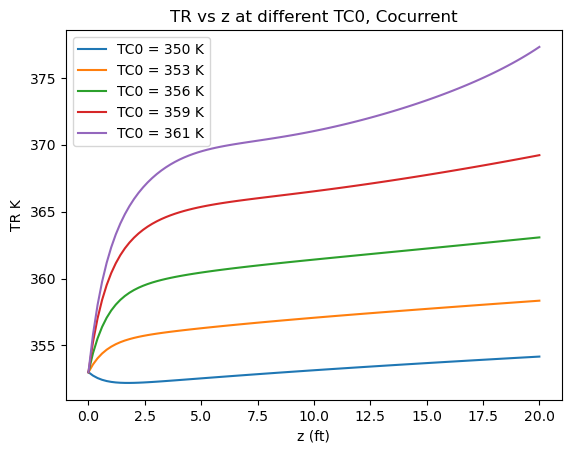

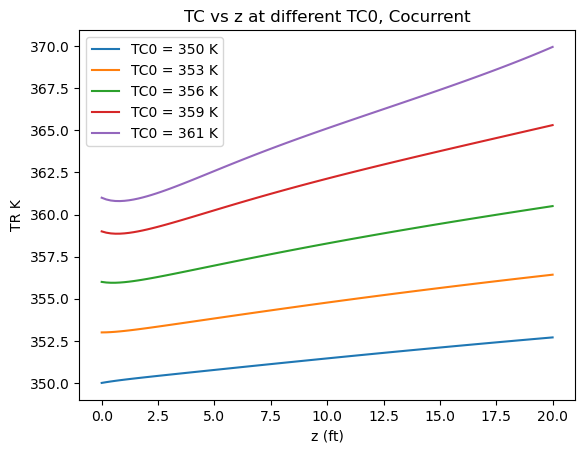

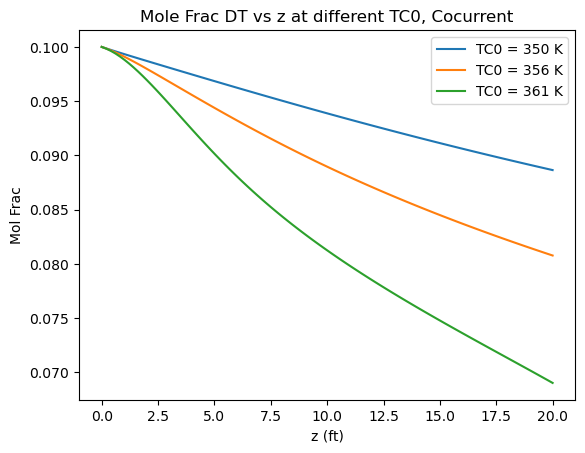

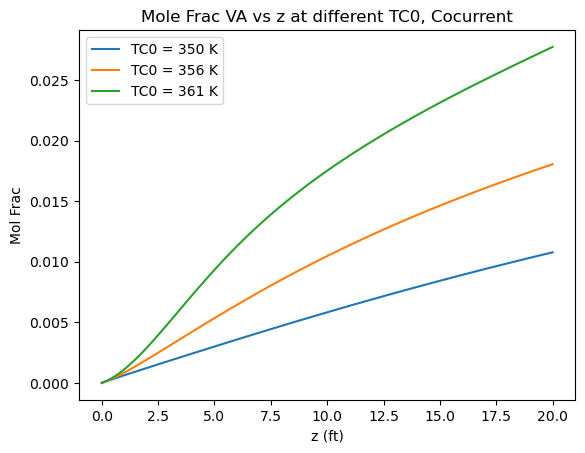

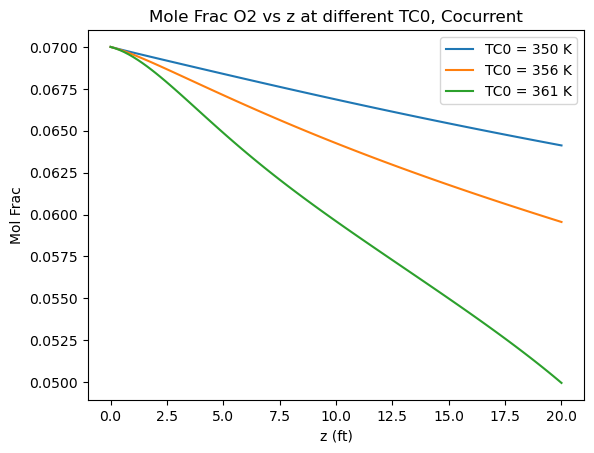

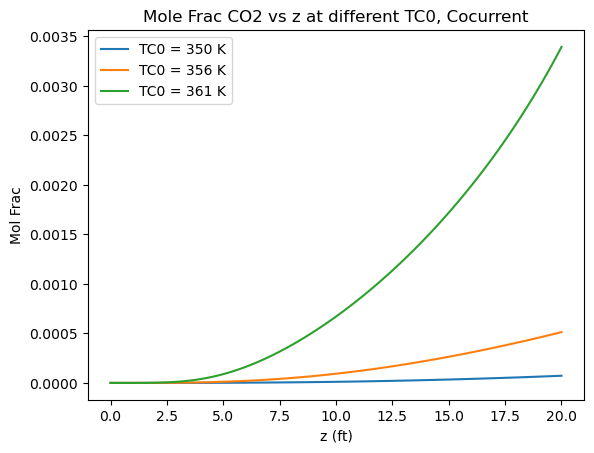

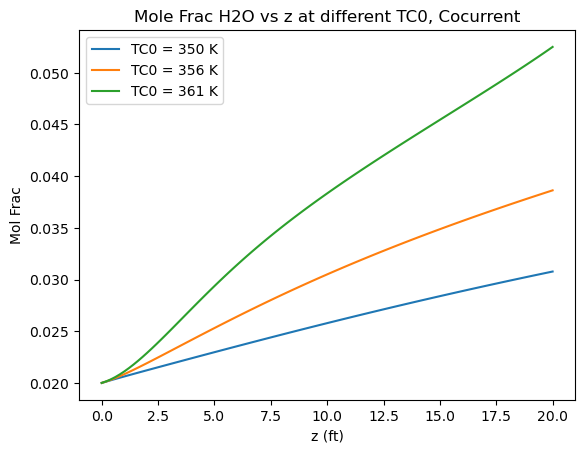

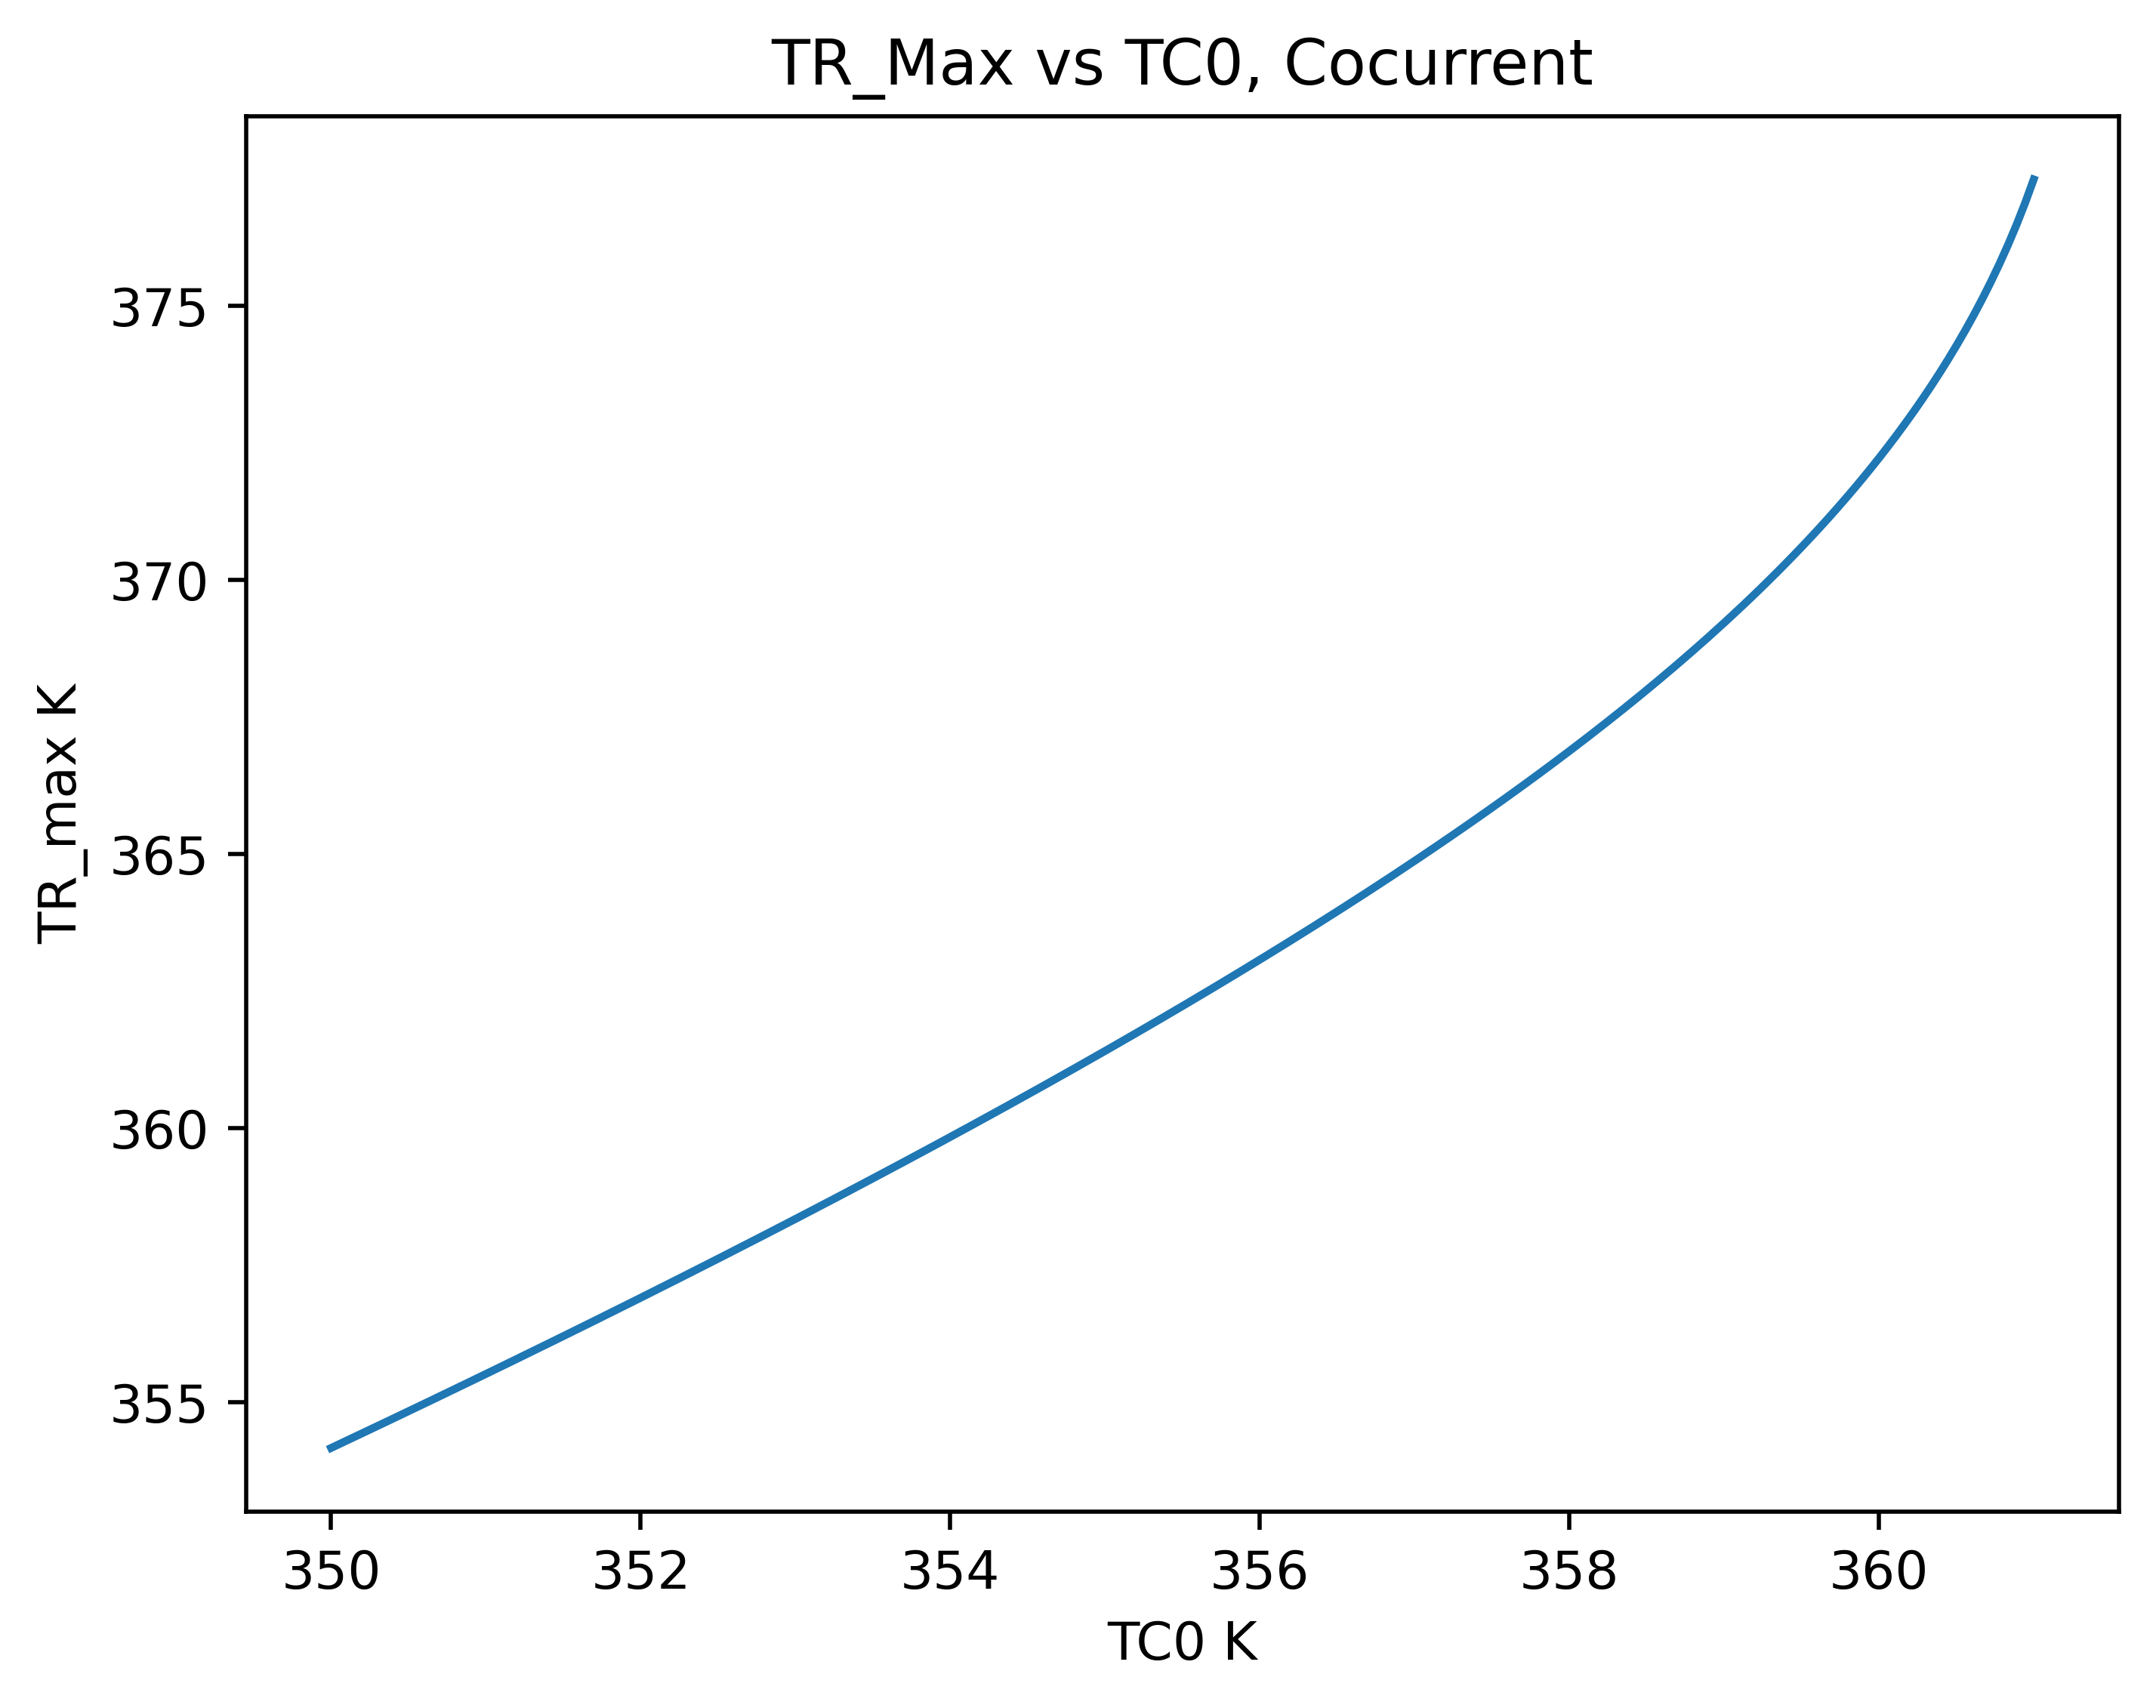

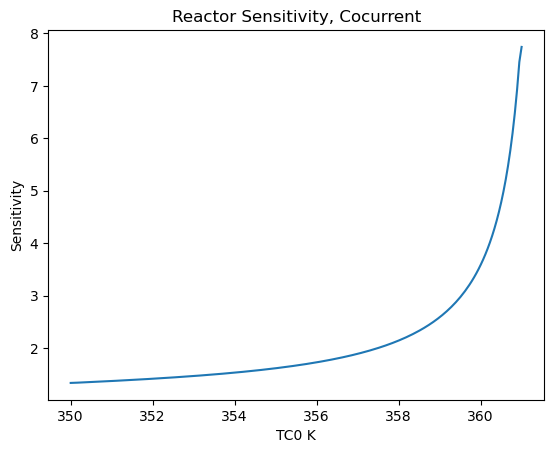

In [6]:
dz = np.linspace(0, 20, 100)
y0 = [X10, X20, X30, X40, X50, MW0, TR0, 0, PT0]
TC0_list = [350, 353, 356, 359, 361]

# Plotting cocurrent
flow = 'Cocurrent'
plot_T_v_z('TR', flow, TC0_list)
plot_T_v_z('TC', flow, TC0_list)
plot_Xi_vs_z(flow, TC0_list)
plot_sensitivity(flow, TC0_list)

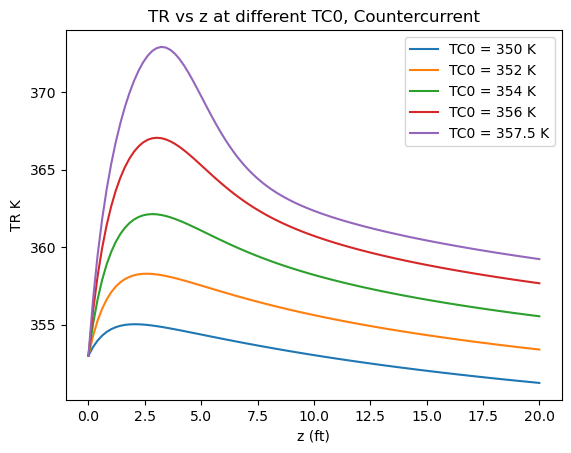

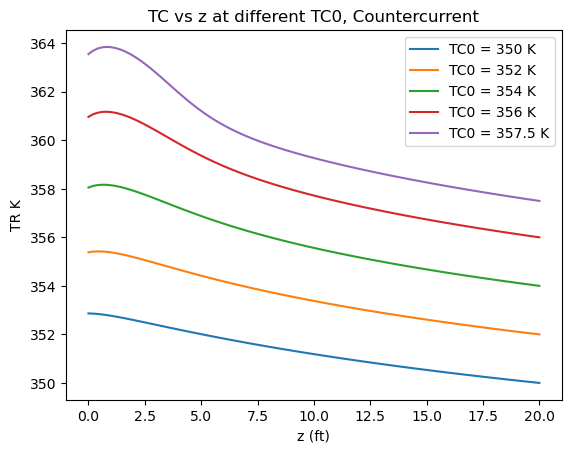

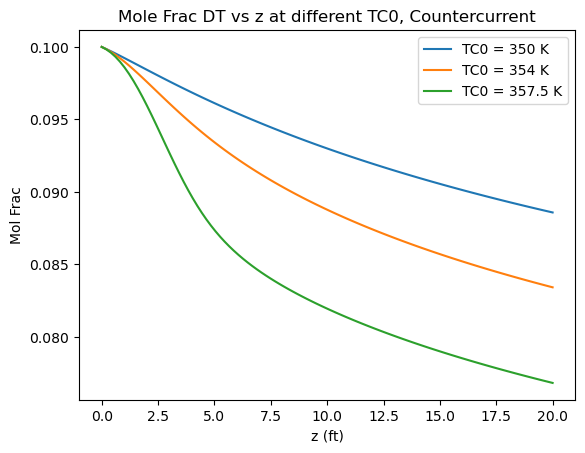

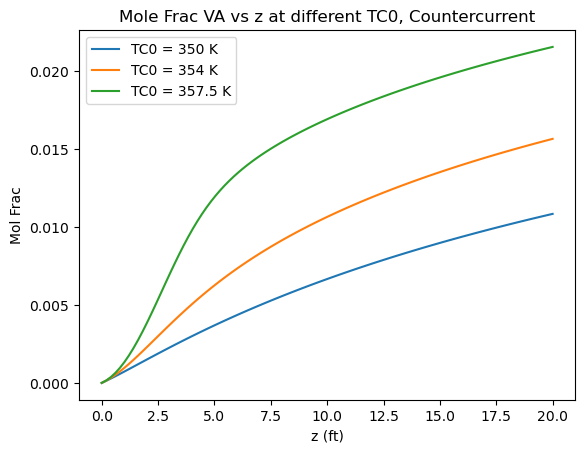

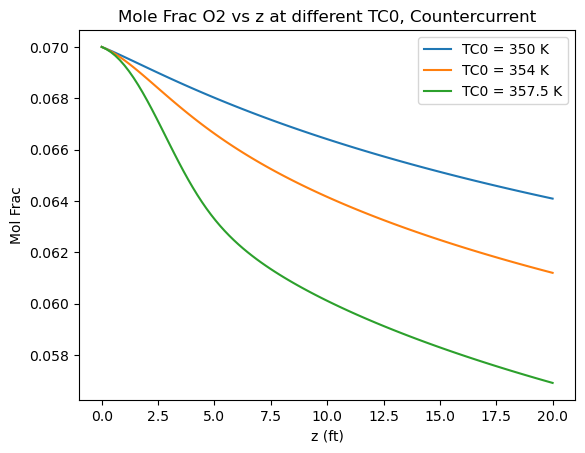

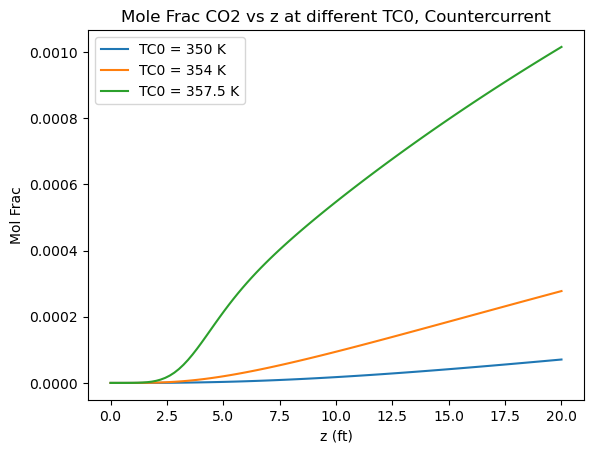

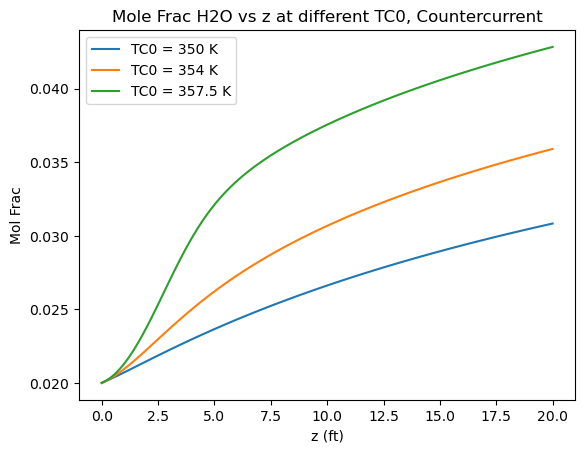

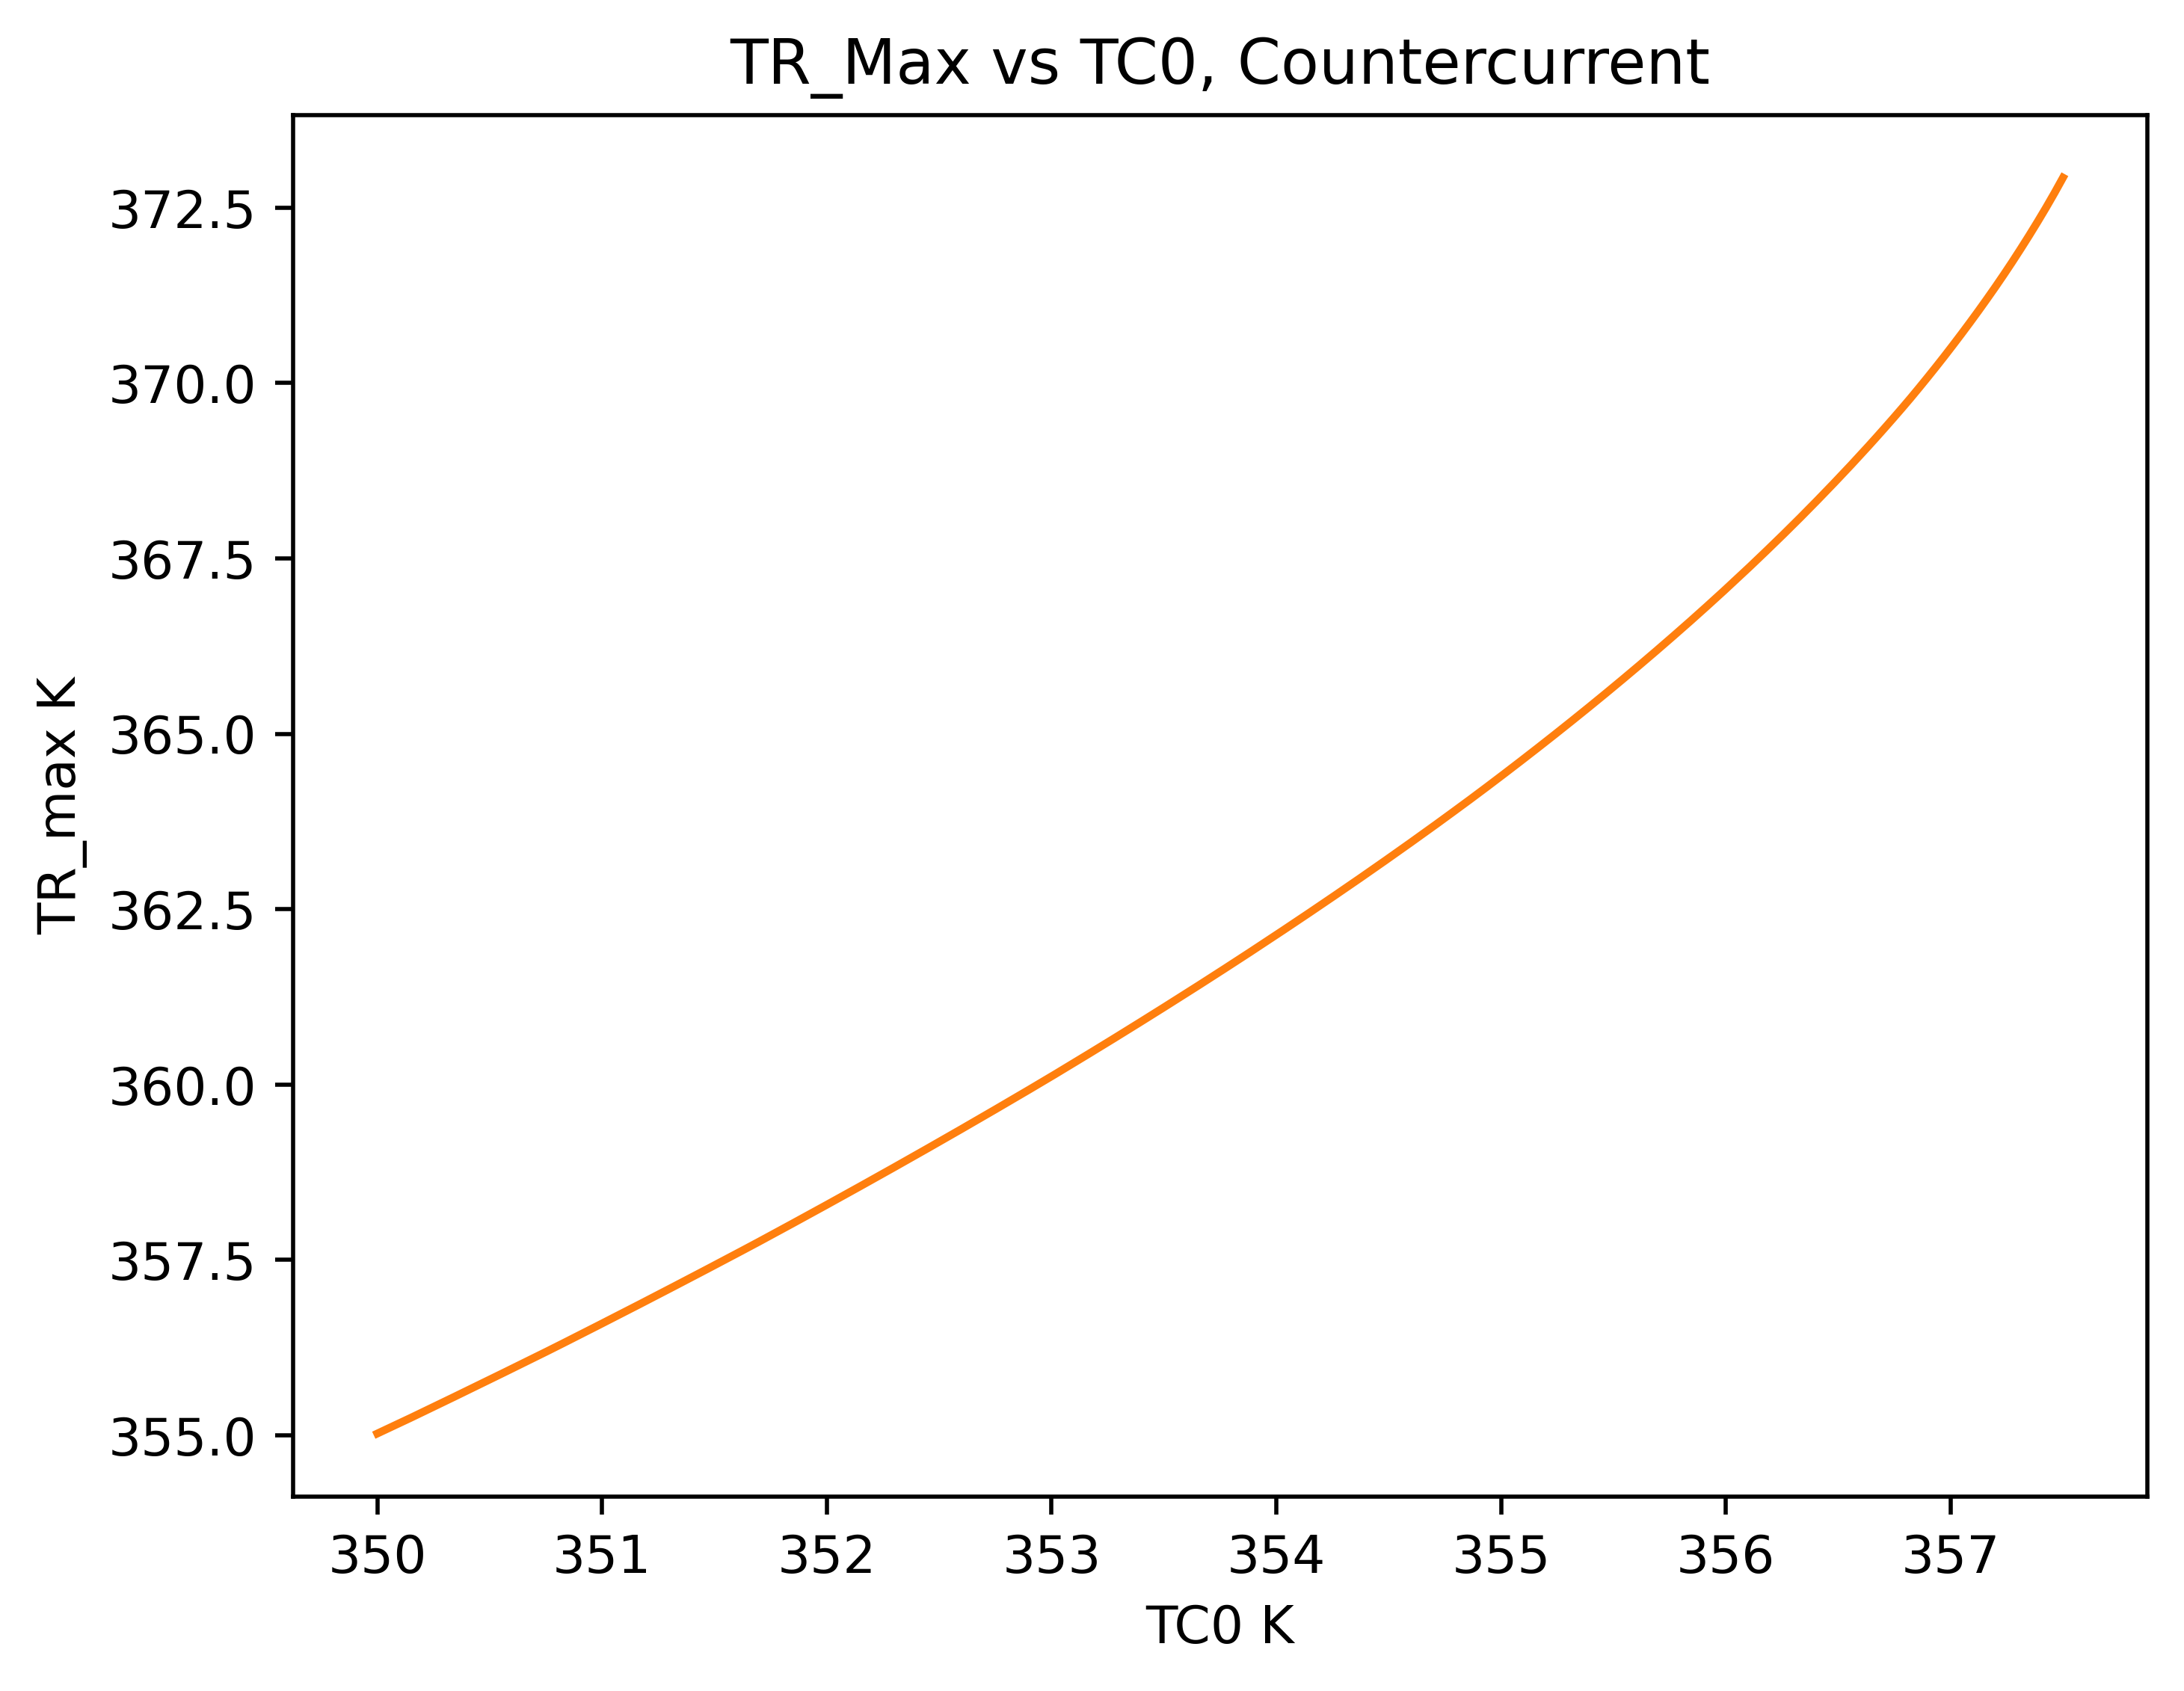

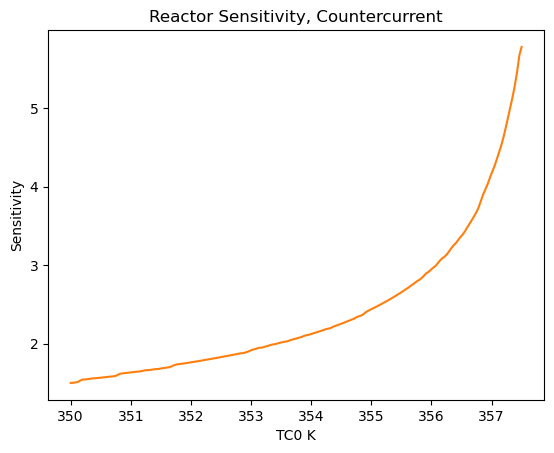

In [7]:
TC0_list = [350, 352, 354, 356, 357.5]

# Plotting cocurrent
flow = 'Countercurrent'
plot_T_v_z('TR', flow, TC0_list)
plot_T_v_z('TC', flow, TC0_list)
plot_Xi_vs_z(flow, TC0_list)
plot_sensitivity(flow, TC0_list)

In [8]:
# overlay plots
TC_pts = 100
TC0_list = np.linspace(TC0, 357, TC_pts)

TR_max_co = []
TR_max_cc = []

for T in TC0_list:
    y0[7] = T
    
    y_co = odeint(odes, y0, dz, args=('Cocurrent',))
    TR_max_co.append(y_co[:,6].max())
    
    y_cc = solve_countercurrent(T, dz)
    TR_max_cc.append(y_cc[:,6].max())

slope_co = np.gradient(TR_max_co, TC0_list)
slope_cc = np.gradient(TR_max_cc, TC0_list) 

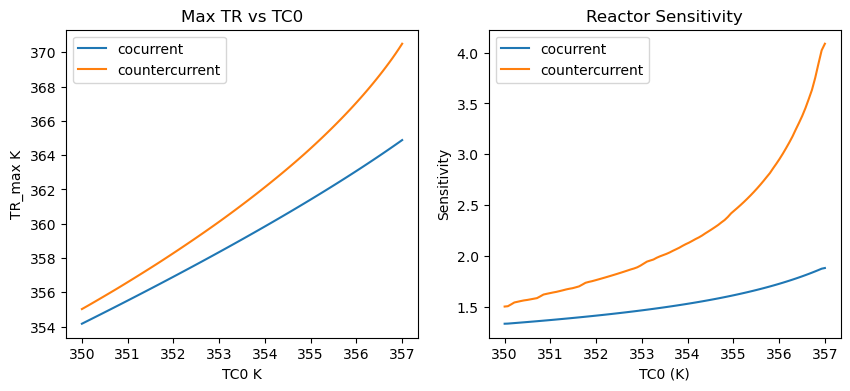

In [9]:
# Plot TR max vs TC0
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(TC0_list, TR_max_co, label='cocurrent')
plt.plot(TC0_list, TR_max_cc, label='countercurrent')
plt.title(f'Max TR vs TC0')
plt.xlabel('TC0 K')
plt.ylabel('TR_max K')
plt.legend(loc='best')

# Plot Sensitivity vs TC0 
plt.subplot(1,2,2)
plt.plot(TC0_list, slope_co, label='cocurrent')
plt.plot(TC0_list, slope_cc, label='countercurrent')
plt.title(f'Reactor Sensitivity')
plt.xlabel('TC0 (K)')
plt.ylabel('Sensitivity')
plt.legend(loc='best')

plt.show()
#plt.savefig(f'Overlayed.png', dpi=500)